## Import Library

In [1]:
import numpy
import pandas as pd
import re
import tensorflow
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

## Membaca dataset

In [2]:
df_sampled = pd.read_csv('sampled_news.csv')

## Menampilkan Ukuran Dataset

In [3]:
df_sampled.shape

(2000, 4)

## Menampilkan Informasi Dataset

In [4]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2000 non-null   int64 
 1   title       2000 non-null   object
 2   text        2000 non-null   object
 3   label       2000 non-null   object
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


## Proporsi Label

Tahap ini menghitung distribusi persentase dari nilai pada kolom label untuk memahami proporsi antara label FAKE dan REAL.

In [5]:
df_sampled['label'].value_counts(normalize=True) * 100

label
FAKE    51.15
REAL    48.85
Name: proportion, dtype: float64

In [6]:
df_sampled

,Unnamed: 0,title,text,label
0,9957,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,FAKE
1,7596,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,FAKE
2,8905,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,FAKE
3,8752,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,FAKE
4,7804,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,FAKE
...,...,...,...,...
1995,7805,Saudis Foil ISIS Terror Attacks on Packed Stadium,Saudi Arabia says it has thwarted two ISIS ter...,FAKE
1996,10287,Police Department Is Being Evicted – Lafayette...,\nAn East Bay police department is now looking...,FAKE
1997,1176,"Trump, Sanders Crush the Competition in New Ha...",Democrat Bernie Sanders and Republican Donald ...,REAL
1998,5951,The words Extraordinary Claims needs to be ban...,The words Extraordinary Claims needs to be ban...,FAKE


## Mengahapus Kolom yang Tidak Diperlukan

In [7]:
if 'Unnamed: 0' in df_sampled.columns:
	df_sampled.drop(columns=['Unnamed: 0'], inplace=True)
if 'title' in df_sampled.columns:
	df_sampled.drop(columns=['title'], inplace=True)
df_sampled.head()

,text,label
0,Will Trump pull a Brexit times ten? What would...,FAKE
1,Clintons Are Under Multiple FBI Investigations...,FAKE
2,Dispatches from Eric Zuesse This piece is cros...,FAKE
3,Print \n[Ed. – Every now and then the facade c...,FAKE
4,Nanny In Jail After Force Feeding Baby To Deat...,FAKE


## Memastikan kolom `text` dan `label` bertipe data string

In [8]:
df_sampled['text'] = df_sampled['text'].astype(str)
df_sampled['label'] = df_sampled['label'].astype(str)
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


## Menghapus duplikat data 

In [9]:
# Mengecek duplikat baris di dataset
duplikat = df_sampled.duplicated(subset='text')
print(duplikat.sum())  # Menghitung jumlah duplikat

# Menampilkan jumlah baris yang duplikat
print(f"Jumlah baris duplikat: {duplikat.sum()}")

# Menampilkan baris-baris yang duplikat
duplikat_baris = df_sampled[df_sampled.duplicated(subset='text')]
print("Baris duplikat:")
print(duplikat_baris)

61
Jumlah baris duplikat: 61
Baris duplikat:
                                                   text label
187                                                      FAKE
188                                                      FAKE
240   Killing Obama administration rules, dismantlin...  REAL
243   A verdict in 2017 could have sweeping conseque...  REAL
253                                                      FAKE
...                                                 ...   ...
1780  The president refuses to say he’d hold to the ...  REAL
1816  Nation Puts 2016 Election Into Perspective By ...  FAKE
1829  The move would make it easier for the Trump ad...  REAL
1877  Nation Puts 2016 Election Into Perspective By ...  FAKE
1936  Killing Obama administration rules, dismantlin...  REAL

[61 rows x 2 columns]


In [10]:
# Menghapus duplikat
df_sampled.drop_duplicates(subset="text", keep='first', inplace=True)  # Menghapus duplikat

# Mengecek duplikat baris di dataset
duplikat = df_sampled.duplicated(subset='text')
print(duplikat.sum())  # Menghitung jumlah duplikat

# Menampilkan jumlah baris yang duplikat
print(f"Jumlah baris duplikat: {duplikat.sum()}")

# Menampilkan baris-baris yang duplikat
duplikat_baris = df_sampled[df_sampled.duplicated(subset='text')]
print("Baris duplikat:")
print(duplikat_baris)

df_sampled.info()

0
Jumlah baris duplikat: 0
Baris duplikat:
Empty DataFrame
Columns: [text, label]
Index: []
<class 'pandas.core.frame.DataFrame'>
Index: 1939 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1939 non-null   object
 1   label   1939 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


## Preprocessing Data

### 1. Menghapus karakter khusus (data cleansing)

In [11]:
def clean_twitter_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Menghapus mention
    text = re.sub(r'#\w+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Menghapus retweet
    text = re.sub(r'https?://\S+', '', text)  # Menghapus URL
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)  # Menghapus karakter non-alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih

    return text

df_sampled['text'] = df_sampled['text'].apply(clean_twitter_text)

### 2. Mengubah teks menjadi lowercase (case folding)

In [12]:
# Fungsi ini mengubah teks menjadi huruf kecil
def case_folding(text):
    # Memeriksa apakah input adalah string
    if isinstance(text, str):
        # Mengubah teks menjadi huruf kecil
        lowercase_text = text.lower()
        # Mengembalikan teks yang sudah diubah menjadi huruf kecil
        return lowercase_text
    else:
        # Jika input bukan string, kembalikan input asli
        return text

# Menerapkan fungsi case_folding ke kolom 'text' dan menyimpannya di kolom 'case_folding'
df_sampled['case_folding'] = df_sampled['text'].apply(case_folding)

# Menampilkan 5 baris pertama dari dataframe
df_sampled.head()

,text,label,case_folding
0,Will Trump pull a Brexit times ten What would ...,FAKE,will trump pull a brexit times ten what would ...
1,Clintons Are Under Multiple FBI Investigations...,FAKE,clintons are under multiple fbi investigations...
2,Dispatches from Eric Zuesse This piece is cros...,FAKE,dispatches from eric zuesse this piece is cros...
3,Print Ed Every now and then the facade cracks ...,FAKE,print ed every now and then the facade cracks ...
4,Nanny In Jail After Force Feeding Baby To Deat...,FAKE,nanny in jail after force feeding baby to deat...


### 3. Tokenisasi

In [13]:
# Fungsi untuk melakukan tokenisasi teks menjadi kata-kata individual
def tokenize(text):
    # Memecah teks menjadi array kata-kata berdasarkan spasi
    tokens = text.split()
    # Mengembalikan array kata-kata hasil tokenisasi
    return tokens

# Menerapkan fungsi tokenize ke kolom 'text' dan menyimpan hasilnya di kolom 'tokenize'
df_sampled['tokenize'] = df_sampled['text'].apply(tokenize)

# Menampilkan 5 baris pertama dari dataframe untuk melihat hasil tokenisasi
df_sampled.head()

,text,label,case_folding,tokenize
0,Will Trump pull a Brexit times ten What would ...,FAKE,will trump pull a brexit times ten what would ...,"[Will, Trump, pull, a, Brexit, times, ten, Wha..."
1,Clintons Are Under Multiple FBI Investigations...,FAKE,clintons are under multiple fbi investigations...,"[Clintons, Are, Under, Multiple, FBI, Investig..."
2,Dispatches from Eric Zuesse This piece is cros...,FAKE,dispatches from eric zuesse this piece is cros...,"[Dispatches, from, Eric, Zuesse, This, piece, ..."
3,Print Ed Every now and then the facade cracks ...,FAKE,print ed every now and then the facade cracks ...,"[Print, Ed, Every, now, and, then, the, facade..."
4,Nanny In Jail After Force Feeding Baby To Deat...,FAKE,nanny in jail after force feeding baby to deat...,"[Nanny, In, Jail, After, Force, Feeding, Baby,..."


### 4. Stopwords Removal

In [14]:
# Mengunduh stopwords
nltk.download('stopwords')

# Mengambil stopwords dari bahasa Inggris
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Fungsi untuk menghapus stopwords dari array kata-kata
def remove_stopwords(text):
    # Membuat list baru dengan kata-kata yang bukan stopwords menggunakan list comprehension
    return [word for word in text if word not in stop_words]

# Menerapkan fungsi remove_stopwords ke kolom 'tokenize' menggunakan lambda function dan menyimpan hasilnya di kolom 'stop_word'
df_sampled['stop_word'] = df_sampled['tokenize'].apply(lambda x: remove_stopwords(x))

# Menampilkan 5 baris pertama dari dataframe untuk melihat hasil penghapusan stopwords
df_sampled.head()

,text,label,case_folding,tokenize,stop_word
0,Will Trump pull a Brexit times ten What would ...,FAKE,will trump pull a brexit times ten what would ...,"[Will, Trump, pull, a, Brexit, times, ten, Wha...","[Will, Trump, pull, Brexit, times, ten, What, ..."
1,Clintons Are Under Multiple FBI Investigations...,FAKE,clintons are under multiple fbi investigations...,"[Clintons, Are, Under, Multiple, FBI, Investig...","[Clintons, Are, Under, Multiple, FBI, Investig..."
2,Dispatches from Eric Zuesse This piece is cros...,FAKE,dispatches from eric zuesse this piece is cros...,"[Dispatches, from, Eric, Zuesse, This, piece, ...","[Dispatches, Eric, Zuesse, This, piece, crossp..."
3,Print Ed Every now and then the facade cracks ...,FAKE,print ed every now and then the facade cracks ...,"[Print, Ed, Every, now, and, then, the, facade...","[Print, Ed, Every, facade, cracks, Somebody, a..."
4,Nanny In Jail After Force Feeding Baby To Deat...,FAKE,nanny in jail after force feeding baby to deat...,"[Nanny, In, Jail, After, Force, Feeding, Baby,...","[Nanny, In, Jail, After, Force, Feeding, Baby,..."


### 5. Stemming

In [16]:
# Mengunduh stemmer dari NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\YOGA
[nltk_data]     PRATAMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# Inisialisasi objek Porter Stemmer untuk melakukan stemming kata
stemmer = PorterStemmer()

# Fungsi untuk melakukan stemming pada setiap kata dalam array
def stemming(text):
    # Menggunakan list comprehension untuk menerapkan stemming pada setiap kata stemmer.stem() akan mengubah kata ke bentuk dasarnya
    return [stemmer.stem(word) for word in text]

# Menerapkan fungsi stemming ke kolom 'stop_word' lambda x: ' '.join() digunakan untuk menggabungkan hasil stemming menjadi string dan menyimpan hasilnya di kolom 'stemming'
df_sampled['stemming'] = df_sampled['stop_word'].apply(lambda x: ' '.join(stemming(x)))

# Menampilkan 5 baris pertama dari dataframe untuk melihat hasil stemming
df_sampled.head()

,text,label,case_folding,tokenize,stop_word,stemming
0,Will Trump pull a Brexit times ten What would ...,FAKE,will trump pull a brexit times ten what would ...,"[Will, Trump, pull, a, Brexit, times, ten, Wha...","[Will, Trump, pull, Brexit, times, ten, What, ...",will trump pull brexit time ten what would tak...
1,Clintons Are Under Multiple FBI Investigations...,FAKE,clintons are under multiple fbi investigations...,"[Clintons, Are, Under, Multiple, FBI, Investig...","[Clintons, Are, Under, Multiple, FBI, Investig...",clinton are under multipl fbi investig agent a...
2,Dispatches from Eric Zuesse This piece is cros...,FAKE,dispatches from eric zuesse this piece is cros...,"[Dispatches, from, Eric, Zuesse, This, piece, ...","[Dispatches, Eric, Zuesse, This, piece, crossp...",dispatch eric zuess thi piec crosspost strateg...
3,Print Ed Every now and then the facade cracks ...,FAKE,print ed every now and then the facade cracks ...,"[Print, Ed, Every, now, and, then, the, facade...","[Print, Ed, Every, facade, cracks, Somebody, a...",print ed everi facad crack somebodi ask questi...
4,Nanny In Jail After Force Feeding Baby To Deat...,FAKE,nanny in jail after force feeding baby to deat...,"[Nanny, In, Jail, After, Force, Feeding, Baby,...","[Nanny, In, Jail, After, Force, Feeding, Baby,...",nanni in jail after forc feed babi to death 2 ...


In [18]:
# Menghitung distribusi persentase label dalam dataset
label_percentages = df_sampled['label'].value_counts(normalize=True) * 100

# Menampilkan persentase untuk setiap label
print("Distribusi label:")
for label, percentage in label_percentages.items():
	print(f"{label}: {percentage:.2f}%")

Distribusi label:
FAKE: 51.68%
REAL: 48.32%


## Reduksi Dimensi dengan SVD

In [19]:
# Melakukan Label Encoding untuk mengubah label kategorikal menjadi numerik
label_encoder = LabelEncoder()

# Mengubah nilai label menjadi angka menggunakan fit_transform
y = label_encoder.fit_transform(df_sampled['label'])

In [20]:
# Melakukan vektorisasi teks menggunakan TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer()
# Mengubah teks dari kolom 'stemming' menjadi matriks TF-IDF 
X = vectorizer.fit_transform(df_sampled['stemming'])

# Melakukan reduksi dimensi menggunakan SVD (Singular Value Decomposition)
# n_components=100 berarti akan mereduksi menjadi 100 fitur
svd = TruncatedSVD(n_components=100)

# Normalisasi hasil SVD agar skala data seragam
normalizer = Normalizer(copy=False)

# Membuat pipeline untuk menggabungkan proses SVD dan normalisasi
lsa = make_pipeline(svd, normalizer)

# Menerapkan LSA (Latent Semantic Analysis) ke data TF-IDF
X_lsa = lsa.fit_transform(X)

# Menampilkan dimensi data sebelum dan sesudah proses SVD
print(f"Shape of the original data: {X.shape}")
print(f"Shape of the data after SVD: {X_lsa.shape}")

Shape of the original data: (1939, 53703)
Shape of the data after SVD: (1939, 100)


## Pemodelan LSTM

In [21]:
# Mengubah bentuk untuk LSTM (samples, timesteps, features)
X_reshaped = X_lsa.reshape(X_lsa.shape[0], 1, X_lsa.shape[1])

In [22]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [23]:
# Membuat model LSTM
model = Sequential([
    LSTM(64, input_shape=(1, 100)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

c:\Users\YOGA PRATAMA\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training LSTM

In [24]:
# Melatih model
history = model.fit(X_train, y_train,
                   epochs=10, 
                   batch_size=32,
                   validation_split=0.2)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6035 - loss: 0.6888 - val_accuracy: 0.8167 - val_loss: 0.6604
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8314 - loss: 0.6402 - val_accuracy: 0.8842 - val_loss: 0.5599
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8763 - loss: 0.5156 - val_accuracy: 0.9068 - val_loss: 0.3883
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8897 - loss: 0.3502 - val_accuracy: 0.9132 - val_loss: 0.2682
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9080 - loss: 0.2485 - val_accuracy: 0.9196 - val_loss: 0.2313
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9215 - loss: 0.1897 - val_accuracy: 0.9228 - val_loss: 0.2235
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9208 - loss: 0.1922 - val_accuracy: 0.9228 - val_loss: 0.2198
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9200 - loss: 0.1831 - val_accuracy: 0.9100 - val_loss

## Pengujian LSTM

In [25]:
# Fungsi untuk mendeteksi apakah kalimat real atau hoax
def detect_real_or_hoax(sentence):
    # Preprocessing kalimat input
    sentence = clean_twitter_text(sentence)
    sentence = case_folding(sentence)
    tokens = tokenize(sentence)
    tokens = remove_stopwords(tokens)
    stemmed_sentence = ' '.join(stemming(tokens))
    
    # Transformasi dengan TF-IDF and SVD
    X_input = vectorizer.transform([stemmed_sentence])
    X_input_lsa = lsa.transform(X_input)
    X_input_reshaped = X_input_lsa.reshape(1, 1, 100)
    
    # Prediksi
    prediction = model.predict(X_input_reshaped)[0]
    label = label_encoder.inverse_transform([round(prediction[0])])
    
    return label[0]

# Meminta input kalimat dari pengguna
kalimat = input("Masukkan kalimat untuk dideteksi: ")
hasil = detect_real_or_hoax(kalimat)
print(f"Kalimat: {kalimat}\nHasil: {hasil}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Kalimat: clinton lost her temper when activities urged her to reject fossil
Hasil: FAKE


## Evaluasi LSTM

In [26]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9019 - loss: 0.2444
Test accuracy: 0.9072


## Visualisasi

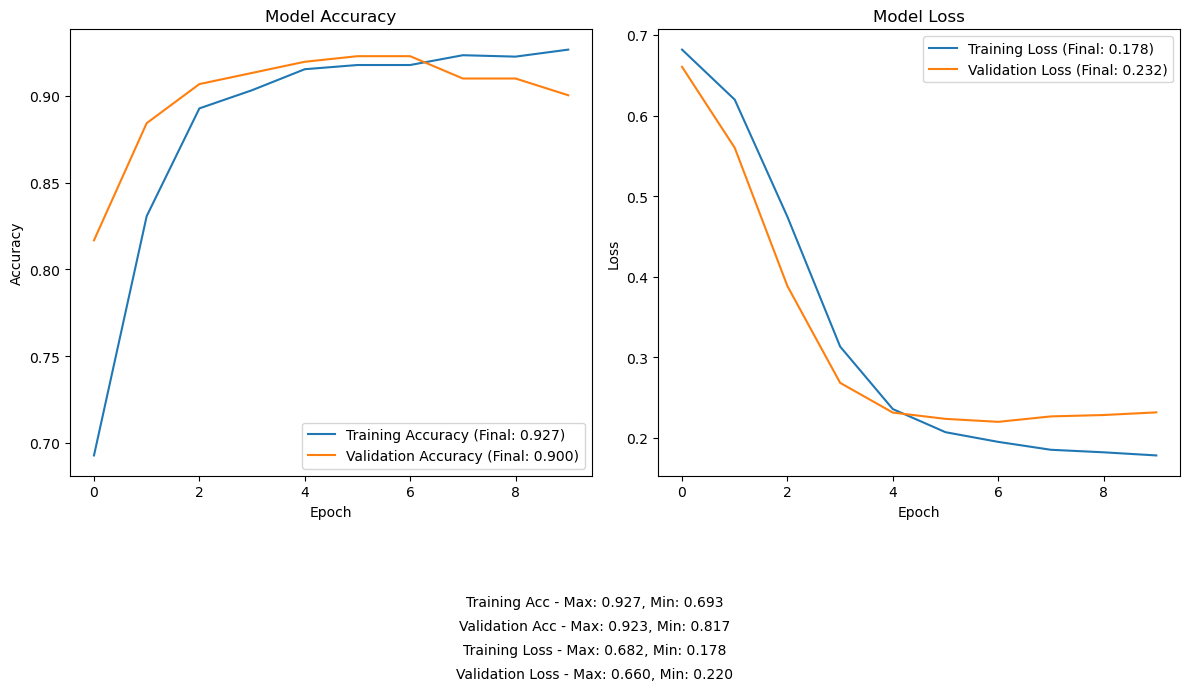

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.89      0.93      0.91       201
        REAL       0.92      0.88      0.90       187

    accuracy                           0.91       388
   macro avg       0.91      0.91      0.91       388
weighted avg       0.91      0.91      0.91       388



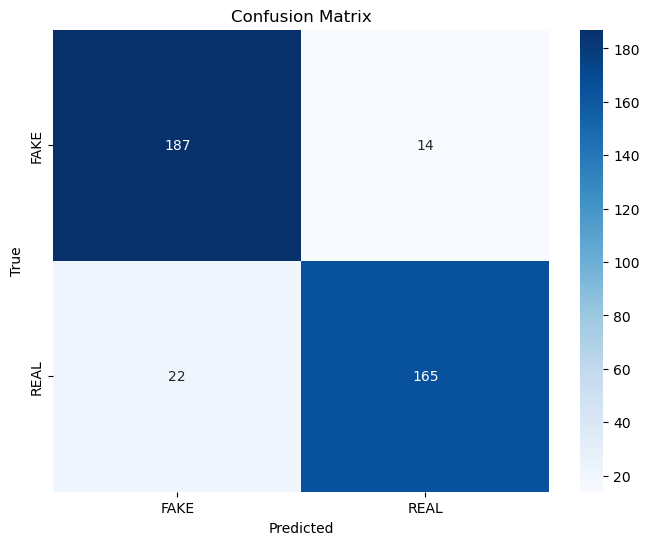


Accuracy for class FAKE: 0.9303

Accuracy for class REAL: 0.8824

Detailed Model Evaluation:
Test Loss: 0.2440
Test Accuracy: 0.9072


In [27]:
# Menampilkan grafik akurasi dan loss dari model
plt.figure(figsize=(12, 6))

# Akurasi subplot
plt.subplot(1, 2, 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label=f'Training Accuracy (Final: {train_acc[-1]:.3f})')
plt.plot(val_acc, label=f'Validation Accuracy (Final: {val_acc[-1]:.3f})')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot  
plt.subplot(1, 2, 2)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label=f'Training Loss (Final: {train_loss[-1]:.3f})')
plt.plot(val_loss, label=f'Validation Loss (Final: {val_loss[-1]:.3f})')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Menambahkan nilai min dan max sebagai teks terpisah di luar plot
fig = plt.gcf()
fig.text(0.5, -0.02, f'Training Acc - Max: {max(train_acc):.3f}, Min: {min(train_acc):.3f}', ha='center', fontsize=10)
fig.text(0.5, -0.06, f'Validation Acc - Max: {max(val_acc):.3f}, Min: {min(val_acc):.3f}', ha='center', fontsize=10)
fig.text(0.5, -0.10, f'Training Loss - Max: {max(train_loss):.3f}, Min: {min(train_loss):.3f}', ha='center', fontsize=10)
fig.text(0.5, -0.14, f'Validation Loss - Max: {max(val_loss):.3f}, Min: {min(val_loss):.3f}', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


# Mendapatkan prediksi untuk metrik evaluasi
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Menampilkan akurasi untuk setiap kelas
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    class_accuracy = accuracy_score(y_test[class_mask], y_pred_classes[class_mask])
    print(f"\nAccuracy for class {class_name}: {class_accuracy:.4f}")

# Menampilkan evaluasi model secara keseluruhan
print("\nDetailed Model Evaluation:")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [28]:
# Fungsi untuk mendeteksi apakah kalimat real atau hoax
def detect_real_or_hoax(sentence):
    # Preprocessing kalimat input
    sentence = clean_twitter_text(sentence)
    sentence = case_folding(sentence)
    tokens = tokenize(sentence)
    tokens = remove_stopwords(tokens)
    stemmed_sentence = ' '.join(stemming(tokens))
    
    # Transformasi dengan TF-IDF and SVD
    X_input = vectorizer.transform([stemmed_sentence])
    X_input_lsa = lsa.transform(X_input)
    X_input_reshaped = X_input_lsa.reshape(1, 1, 100)
    
    # Prediksi
    prediction = model.predict(X_input_reshaped)[0]
    label = label_encoder.inverse_transform([round(prediction[0])])
    
    return label[0]

# Meminta input kalimat dari pengguna
kalimat = input("Masukkan kalimat untuk dideteksi: ")
hasil = detect_real_or_hoax(kalimat)
print(f"Kalimat: {kalimat}\nHasil: {hasil}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Kalimat: clinton lost her temper when activities urged her to reject fossil
Hasil: FAKE
